# MPFST Example: Seismic Shell‑Jump Hazard vs mℓ (IRIS via ObsPy)
This notebook uses **ObsPy** to fetch broadband seismic waveforms from IRIS for a short window around a known event,
then computes coherence metrics and **SSM shell‑jumps**, and plots **hazard vs mℓ**. Internet required.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from mpfst.coherence.metrics import spectral_slope_gamma, hurst_dfa, heavy_tail_mu_hill
from mpfst.coherence.meter import compute_m_l
from mpfst.spectral.octave_jump import detect_shell_jumps_series
from mpfst.nulls.time_shuffle import time_shuffle

# Parameters: network/station/channel and time window (edit as needed)
client = Client('IRIS')
net, sta, loc, cha = 'IU','ANMO','00','BHZ'
t0 = UTCDateTime('2010-02-27T06:45:00')  # Chile M8.8 mainshock window (example)
t1 = t0 + 60*10
st = client.get_waveforms(net, sta, loc, cha, t0, t1)
tr = st[0].detrend('linear'); tr.filter('bandpass', freqmin=0.05, freqmax=5.0)
x = tr.data.astype(float); fs = tr.stats.sampling_rate
print(f'Fetched {net}.{sta}.{cha}, fs={fs}')


Fetched IU.ANMO.BHZ, fs=20.0


## Coherence metrics → mℓ (sliding windows) and SSM shell‑jumps

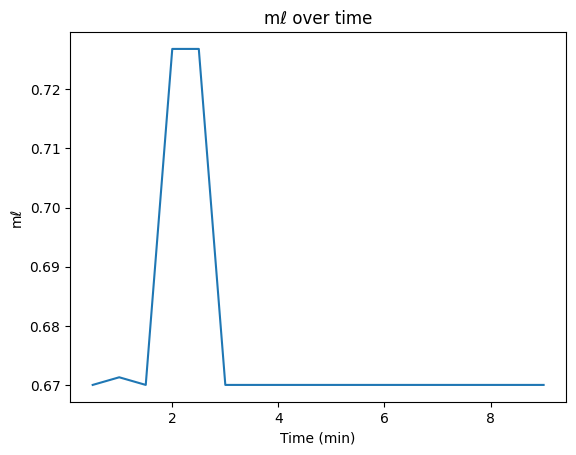

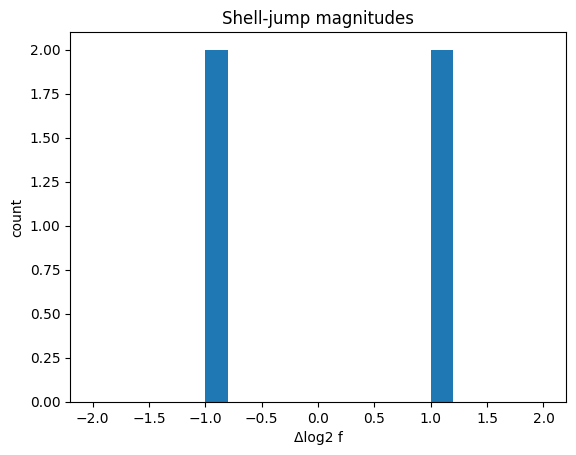

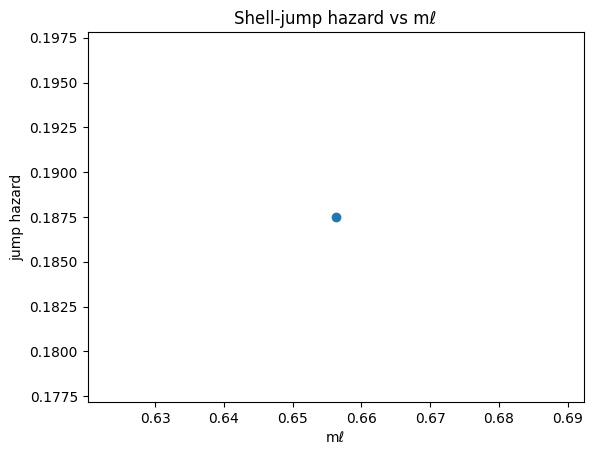

In [2]:
win = int(fs*60)   # 60 s
hop = int(fs*30)   # 50% overlap
ml, times = [], []
for start in range(0, len(x)-win, hop):
    seg = x[start:start+win]
    mu = heavy_tail_mu_hill(seg)
    ga = spectral_slope_gamma(seg, fs=fs, fmin=0.05, fmax=2.0)
    H  = hurst_dfa(seg, min_scale=8, max_scale=min(4096, win//2))
    ml.append(compute_m_l(mu, ga, H)); times.append((start+win/2)/fs)
ml = np.array(ml); times = np.array(times)

out = detect_shell_jumps_series(x, fs, fmin=0.05, fmax=5.0, n_bands=8, energy_min=None, min_gap=int(fs*5))
jumps = out['jumps']
jt = np.array([j[0]/fs for j in jumps])
deltas = np.array([j[3] for j in jumps])
event_flags = np.zeros_like(ml, dtype=bool)
for t in jt:
    idx = np.argmin(np.abs(times - t))
    if 0<=idx<len(event_flags): event_flags[idx]=True
from mpfst.gating.hazard import hazard_curve
c, h = hazard_curve(ml, event_flags, bins=16)
plt.figure(); plt.plot(times/60.0, ml); plt.xlabel('Time (min)'); plt.ylabel('mℓ'); plt.title('mℓ over time'); plt.show()
plt.figure(); plt.hist(deltas, bins=np.linspace(-2,2,21)); plt.xlabel('Δlog2 f'); plt.ylabel('count'); plt.title('Shell‑jump magnitudes'); plt.show()
plt.figure(); plt.plot(c, h, marker='o'); plt.xlabel('mℓ'); plt.ylabel('jump hazard'); plt.title('Shell‑jump hazard vs mℓ'); plt.show()


## Null (time‑shuffle) — the hazard vs mℓ peak should collapse

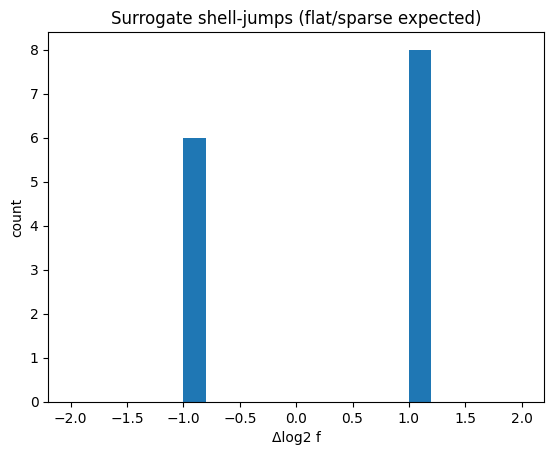

In [3]:
x_s = time_shuffle(x, block=int(fs*10), seed=123)
out_s = detect_shell_jumps_series(x_s, fs, fmin=0.05, fmax=5.0, n_bands=8, energy_min=None, min_gap=int(fs*5))
jumps_s = out_s['jumps']
deltas_s = np.array([j[3] for j in jumps_s])
plt.figure();
if deltas_s.size>0:
    plt.hist(deltas_s, bins=np.linspace(-2,2,21))
else:
    plt.plot([],[])
plt.xlabel('Δlog2 f'); plt.ylabel('count'); plt.title('Surrogate shell‑jumps (flat/sparse expected)'); plt.show()
